In [1]:
import pandas as pd
import urllib.request
import zipfile

In [2]:
url="https://github.com/mattharrison/datasets/raw/master/data/kaggle-survey-2018.zip"
fname='kaggle-survey-2018.zip'
member_name='multipleChoiceResponses.csv'


In [3]:
def extract_zip(src,dest, member_name):
    url=src
    fname=dest
    fin=urllib.request.urlopen(url)
    data=fin.read()

    with open(dest,mode='wb') as fout:
        fout.write(data)
    with zipfile.ZipFile(dest) as z:
        kag=pd.read_csv(z.open(member_name))
        kag_question=kag.iloc[0]
        raw=kag.iloc[1:]
        return raw

In [4]:
raw = extract_zip(url,fname,member_name)

C:\Users\Tyreek ALEXANDER\AppData\Local\Temp\ipykernel_9156\2146811015.py:10: DtypeWarning: Columns (0,2,8,10,21,23,24,25,26,27,28,44,56,64,83,85,87,107,109,123,125,150,157,172,174,194,210,218,219,223,246,249,262,264,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,304,306,325,326,329,341,368,371,384,385,389,390,391,393,394) have mixed types. Specify dtype option on import or set low_memory=False.
  kag=pd.read_csv(z.open(member_name))


In [5]:
def tweak_kag(df_:pd.DataFrame)-> pd.DataFrame:
    return(df_
           .assign(age=df_['Q2'].str.slice(0,2).astype(int),
                   education=df_['Q4'].replace({"Master’s degree":18,"Bachelor’s degree":16,"Doctoral degree":20,"Some college/university study without earning a bachelor’s degree":13,"Professional degree":19,"I prefer not to answer":None,"No formal education past high school":12}),
                   major=(df_['Q5']
                          .pipe(topn,n=3)
                          .replace({'Computer science (software engineering, etc.)':'cs',
                                    "Engineering (non-computer focused)":'eng',
                                    "Mathematics or statistcs":'stat',})
                                    ),
                    years_exp=(df_['Q8'].str.replace('+','',regex=False)
                               .str.split('-',expand=True)
                               .iloc[:,0]
                               .astype(float)
                               ),
                    compensation=(df_['Q9']
                                .str.replace('+','',regex=False)
                                .str.replace(',','',regex=False)
                                .str.replace('500000','500',regex=False)
                                .str.replace('I do not wish to disclose my approximate yearly compensation','0',regex=False)
                                .str.split('-',expand=True)
                                .iloc[:,0]
                                .fillna(0)
                                .astype(int)
                                .mul(1_000)
                                ),
                    python=df_['Q16_Part_1'].fillna(0).replace('Python',1),
                    r=df_['Q16_Part_2'].fillna(0).replace('R',1),
                    sql=df_['Q16_Part_3'].fillna(0).replace('SQL',1)
                    )#end assign
                .rename(columns=lambda col:col.replace(' ','_'))
                .loc[:,'Q1,Q3,age,education,major,years_exp,compensation,python,r,sql'.split(',')]
    

    )
def topn(ser,n=5,default='other'):
    counts=ser.value_counts()
    return ser.where(ser.isin(counts.index[:n]),default)

In [6]:
from feature_engine import encoding,imputation
from sklearn import base,pipeline

class TweakKagTransformer(base.BaseEstimator,base.TransformerMixin):
    def __inint__(self,ycol=None):
        self.ycol=ycol
    def transform(self,X):
        return tweak_kag(X)
    def fit(self,X,y=None):
        return self



In [7]:
def get_rawX_y(df,col_y):
    raw=(df.query('Q3.isin(["United States of America","China","India"]) and Q6.isin(["Data Scientist","Software Engineer"])'))
    return raw.drop(columns=[col_y]) , raw[col_y]

# pipeline
kag_pl=pipeline.Pipeline([('tweak',TweakKagTransformer()),('cat',encoding.OneHotEncoder(top_categories=5,drop_last=True,variables=['Q1','Q3','major'])),('num_impute',imputation.MeanMedianImputer(imputation_method='median',variables=['education','years_exp']))]
)

In [8]:
from sklearn import model_selection
kag_X,kag_y=get_rawX_y(raw,'Q6')

kag_X_train,kag_X_test,kag_y_train,kag_y_test=model_selection.train_test_split(kag_X,kag_y,test_size=.3,random_state=42,stratify=kag_y)

Xtrain=kag_pl.fit_transform(kag_X_train,kag_y_train)
Xtest=kag_pl.transform(kag_X_test)
print(Xtrain)

       age  education  years_exp  compensation  python  r  sql  Q1_Male  \
587     25       18.0        4.0             0       1  0    1        1   
3065    22       16.0        1.0         10000       1  0    0        1   
8435    22       18.0        1.0             0       1  0    0        1   
3110    40       20.0        3.0        125000       1  0    1        0   
16372   45       12.0        5.0        100000       1  0    1        1   
...    ...        ...        ...           ...     ... ..  ...      ...   
16608   25       16.0        2.0         10000       0  0    1        1   
7325    18       16.0        1.0         30000       1  0    1        1   
21810   18       16.0        2.0             0       0  0    0        1   
4917    25       18.0        1.0        100000       1  0    1        1   
639     25       18.0        1.0         10000       1  0    0        0   

       Q1_Female  Q1_Prefer not to say  Q1_Prefer to self-describe  \
587            0             

Exploratory data analysis

In [9]:
(Xtrain
 .assign(data_scientist=kag_y_train=='Data Scientist')
 .corr(method='spearman')
 .style
 .background_gradient(cmap='RdBu',vmax=1,vmin=-1)
 .set_sticky(axis='index')
)

,age,education,years_exp,compensation,python,r,sql,Q1_Male,Q1_Female,Q1_Prefer not to say,Q1_Prefer to self-describe,Q3_United States of America,Q3_India,Q3_China,major_cs,major_other,major_eng,major_Mathematics or statistics,data_scientist
age,1.000000,0.345717,0.644863,0.451349,0.046651,0.127667,0.134325,0.014277,-0.033693,0.051232,0.041474,0.371123,-0.363626,-0.023384,-0.223529,0.201910,0.006262,0.073864,0.075440
education,0.345717,1.000000,0.098849,0.241393,0.060259,0.151244,0.066620,-0.079534,0.064777,0.060984,0.002701,0.272790,-0.273408,-0.006441,-0.216724,0.164771,-0.001043,0.121294,0.266717
years_exp,0.644863,0.098849,1.000000,0.255164,-0.055408,0.012090,0.050181,0.083624,-0.097564,0.034470,0.016784,0.117912,-0.136666,0.029630,-0.046551,0.018267,0.004264,0.042917,-0.145461
compensation,0.451349,0.241393,0.255164,1.000000,0.165070,0.171485,0.201336,0.000967,0.002912,-0.035554,0.049881,0.616759,-0.556154,-0.123281,-0.225934,0.241580,-0.060256,0.109100,0.174434
python,0.046651,0.060259,-0.055408,0.165070,1.000000,0.183665,0.287957,0.039944,-0.039207,-0.006729,-0.000553,0.052339,-0.043101,-0.017642,-0.095136,0.093887,0.008640,0.013474,0.121741
r,0.127667,0.151244,0.012090,0.171485,0.183665,1.000000,0.276862,-0.066982,0.068157,0.004831,-0.004454,0.178682,-0.105625,-0.133029,-0.205538,0.139994,-0.022082,0.162942,0.329124
sql,0.134325,0.066620,0.050181,0.201336,0.287957,0.276862,1.000000,-0.026692,0.032639,-0.010814,-0.018499,0.166587,-0.107382,-0.108406,-0.130081,0.109862,-0.012964,0.073906,0.117941
Q1_Male,0.014277,-0.079534,0.083624,0.000967,0.039944,-0.066982,-0.026692,1.000000,-0.957007,-0.222963,-0.094664,-0.144665,0.116961,0.052566,0.062605,-0.071139,0.028492,-0.039544,-0.091126
Q1_Female,-0.033693,0.064777,-0.097564,0.002912,-0.039207,0.068157,0.032639,-0.957007,1.000000,-0.045225,-0.019201,0.131051,-0.105490,-0.048434,-0.049753,0.064054,-0.034760,0.036779,0.086614
Q1_Prefer not to say,0.051232,0.060984,0.034470,-0.035554,-0.006729,0.004831,-0.010814,-0.222963,-0.045225,1.000000,-0.004473,0.046366,-0.038587,-0.014918,-0.045908,0.010336,0.029149,0.021052,0.018540


This is spearmans correlation efficient of features.

the value ranges from -1 : 1.
a pos sitive correlation means as one value increases, the other value also tends increases.
a 0 correlation means [there is no relationship] one value is unchanged while the other value increases.
a negative correlation means that as one variable increases the other tends to goes up.

spearmans coefficient uses ordinal data as well as cardinal/continuous

Bar plot


<AxesSubplot:xlabel='r'>

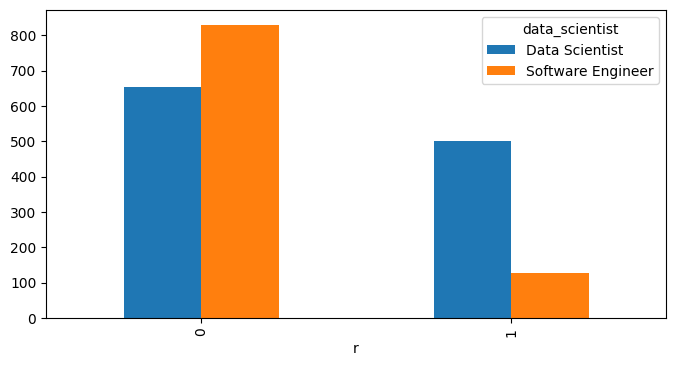

In [10]:
import matplotlib.pyplot as plt

fig, ax=plt.subplots(figsize=(8,4))
(Xtrain
 .assign(data_scientist=kag_y_train)
 .groupby('r')
 .data_scientist
 .value_counts()
 .unstack()
 .plot.bar(ax=ax))

above: the more persons who use R the more they are data scientists; the less the are software engineers

bar plot showing r usagae among data scientitst and software engineers

<AxesSubplot:xlabel='major_cs'>

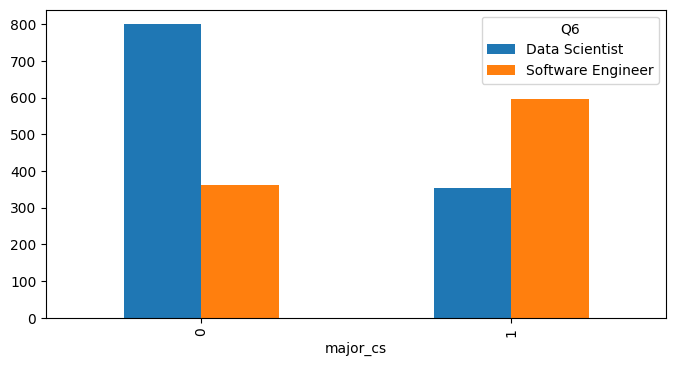

In [11]:

fig, ax = plt.subplots(figsize=(8, 4))
(pd.crosstab(index=Xtrain['major_cs'],
    columns=kag_y)
.plot.bar(ax=ax)
)

scatterplot of years of experience and compensation.


<AxesSubplot:xlabel='years_exp', ylabel='compensation'>

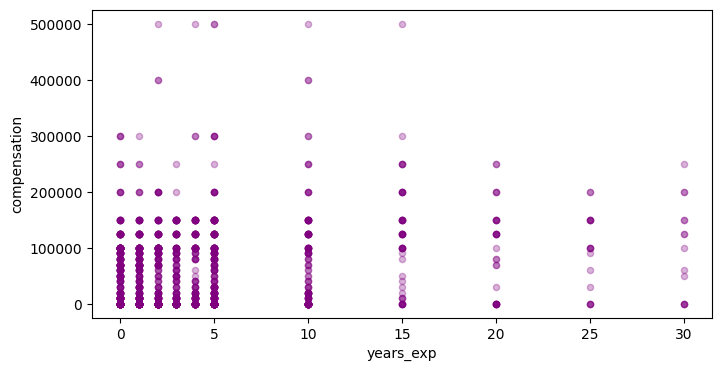

In [12]:
fig,ax=plt.subplots(figsize=(8,4))
(Xtrain
 .plot.scatter(x='years_exp',y='compensation',alpha=.3,ax=ax,c='purple')
 )

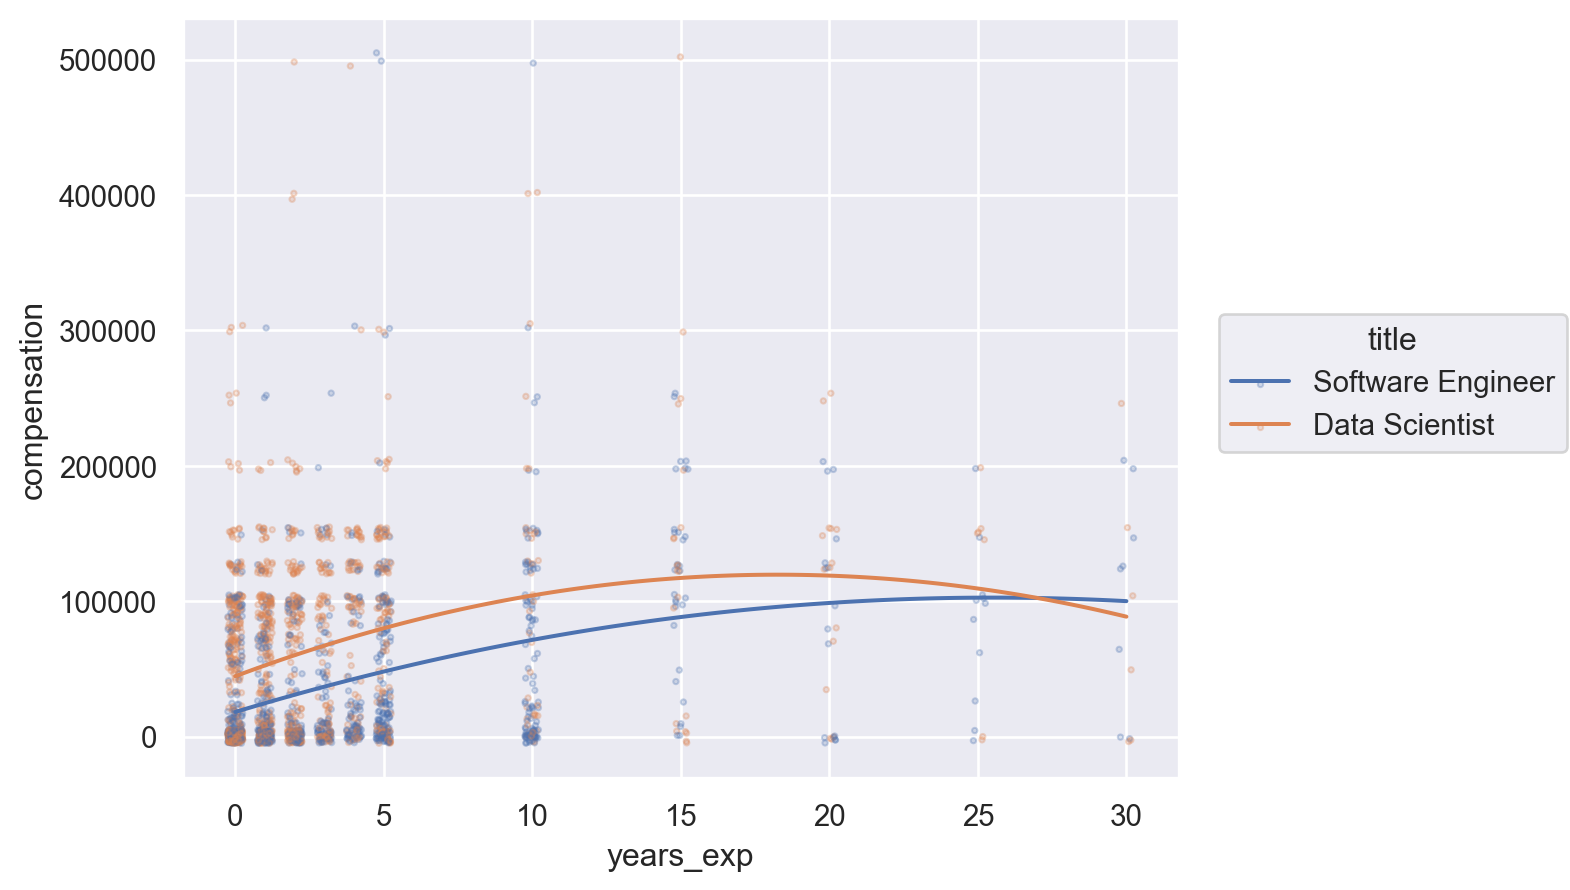

<Figure size 800x400 with 0 Axes>

In [13]:
import seaborn.objects as so
fig=plt.figure(figsize=(8,4))
(so
 .Plot(Xtrain.assign(title=kag_y_train),x='years_exp',y='compensation',color='title')
 .add(so.Dots(alpha=.3,pointsize=2),so.Jitter(x=.5,y=10_000))
 .add(so.Line(),so.PolyFit())
#  .on(fig)
 .plot()
)

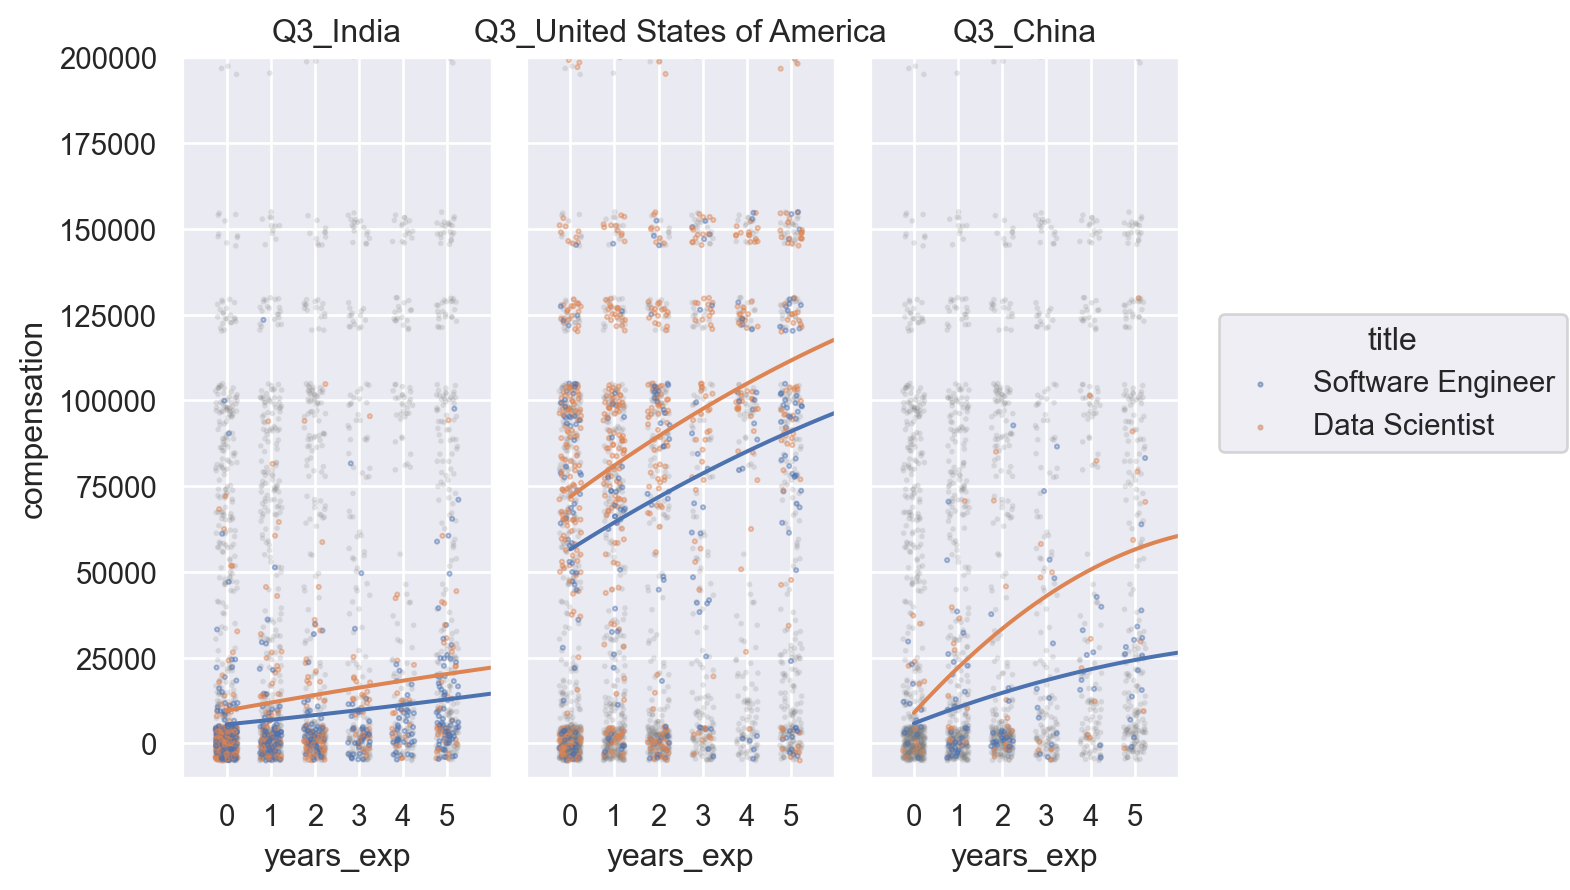

<Figure size 800x400 with 0 Axes>

In [14]:
fig=plt.figure(figsize=(8,4))
(so
 .Plot(Xtrain
       #.query('compensation<200_000 and years_exp<16')
       .assign(
        title=kag_y_train,
        country=(Xtrain
                 .loc[:,'Q3_United States of America':'Q3_China']
                 .idxmax(axis='columns')
                 )
        ),x='years_exp',y='compensation',color='title')
        .facet('country')
        .add(so.Dots(alpha=.01,pointsize=2,color='grey'),so.Jitter(x=.5,y=10_000),col=None)
        .add(so.Dots(alpha=.5,pointsize=1.5),so.Jitter(x=.5,y=10_000))
        .add(so.Line(pointsize=1),so.PolyFit(order=2))
        .scale(x=so.Continuous().tick(at=[0,1,2,3,4,5]))
        .limit(y=(-10_000,200_000),x=(-1,6))
        .plot()
        )

In [15]:
from sklearn import tree
stump_dt=tree.DecisionTreeClassifier(max_depth=1)
Xtrain=kag_pl.fit_transform(kag_X_train)
stump_dt.fit(Xtrain,kag_y_train)

DecisionTreeClassifier(max_depth=1)

[Text(0.5, 0.75, 'r <= 0.5\ngini = 0.496\nsamples = 2110\nvalue = [1153, 957]\nclass = Data Scientist'),
 Text(0.25, 0.25, 'gini = 0.493\nsamples = 1484\nvalue = [653, 831]\nclass = Software Engineer'),
 Text(0.75, 0.25, 'gini = 0.322\nsamples = 626\nvalue = [500, 126]\nclass = Data Scientist')]

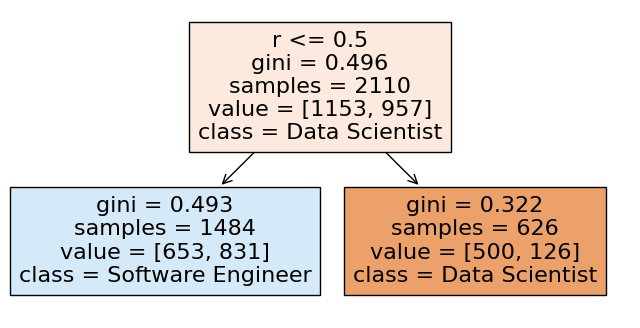

In [16]:
fig,ax=plt.subplots(figsize=(8,4))
features= list(c for c in Xtrain.columns)
tree.plot_tree(stump_dt,
               feature_names=features,
               filled=True,
               class_names=stump_dt.classes_,
               ax=ax)

In [17]:
Xtest=kag_pl.transform(kag_X_test)
stump_dt.score(Xtest,kag_y_test)

0.6243093922651933

In [18]:
# a dummy model

from sklearn import dummy

dummy_model=dummy.DummyClassifier()
dummy_model.fit(Xtrain,kag_y_train)
dummy_model.score(Xtest,kag_y_test)

0.5458563535911602

In [19]:
from sklearn import preprocessing
label_encoder=preprocessing.LabelEncoder()

ytrain=label_encoder.fit_transform(kag_y_train)
ytest=label_encoder.transform(kag_y_test)

# show encoded value via index [0,1,2,...,n]
label_encoder.classes_

array(['Data Scientist', 'Software Engineer'], dtype=object)

In [20]:
#XGBoosted stump
import xgboost as xgb
kag_stump=xgb.XGBClassifier(n_estimators=1,max_depth=1)
kag_stump.fit(Xtrain,ytrain)
kag_stump.score(Xtest,ytest)

0.6243093922651933


logistic regression predicts true or false
fits a s-shaped curve
predicts probabilities
usually used for classification 

https://www.youtube.com/watch?v=yIYKR4sgzI8

In [21]:
underfit=tree.DecisionTreeClassifier(max_depth=1)
Xtrain=kag_pl.fit_transform(kag_X_train)
underfit.fit(Xtrain,kag_y_train)
underfit.score(Xtest,kag_y_test)

0.6243093922651933

In [22]:
hi_variance=tree.DecisionTreeClassifier(max_depth=7)
# max depth = none overfits the tree
# overfitting is memorizing the training data 
# understance variance as 'deciding factors'
Xtrain=kag_pl.fit_transform(kag_X_train)
hi_variance.fit(Xtrain,kag_y_train)
hi_variance.score(Xtest,kag_y_test)

0.7348066298342542

[Text(0.5, 0.875, 'r <= 0.5\ngini = 0.496\nsamples = 2110\nvalue = [1153, 957]\nclass = Data Scientist'),
 Text(0.25, 0.625, 'major_cs <= 0.5\ngini = 0.493\nsamples = 1484\nvalue = [653, 831]\nclass = Software Engineer'),
 Text(0.125, 0.375, 'Q3_United States of America <= 0.5\ngini = 0.49\nsamples = 718\nvalue = [410, 308]\nclass = Data Scientist'),
 Text(0.0625, 0.125, '\n  (...)  \n'),
 Text(0.1875, 0.125, '\n  (...)  \n'),
 Text(0.375, 0.375, 'years_exp <= 2.5\ngini = 0.433\nsamples = 766\nvalue = [243, 523]\nclass = Software Engineer'),
 Text(0.3125, 0.125, '\n  (...)  \n'),
 Text(0.4375, 0.125, '\n  (...)  \n'),
 Text(0.75, 0.625, 'major_cs <= 0.5\ngini = 0.322\nsamples = 626\nvalue = [500, 126]\nclass = Data Scientist'),
 Text(0.625, 0.375, 'years_exp <= 22.5\ngini = 0.211\nsamples = 443\nvalue = [390, 53]\nclass = Data Scientist'),
 Text(0.5625, 0.125, '\n  (...)  \n'),
 Text(0.6875, 0.125, '\n  (...)  \n'),
 Text(0.875, 0.375, 'years_exp <= 7.5\ngini = 0.48\nsamples = 183\nval

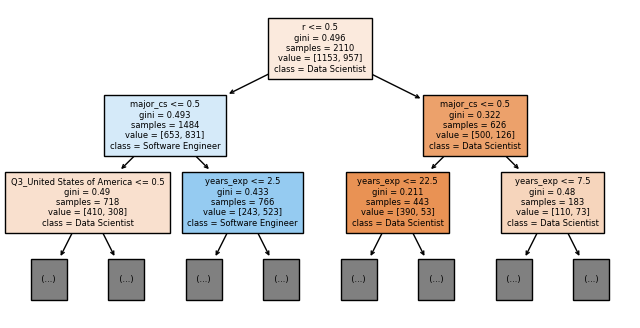

In [23]:
fig,ax=plt.subplots(figsize=(8,4))
features=list(c for c in Xtrain.columns)
tree.plot_tree(hi_variance,feature_names=features,filled=True,class_names=hi_variance.classes_,max_depth=2,fontsize=6)

In [24]:
hi_variance.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 7,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [25]:
# a handmade validation curve
# accuracies=[]
# for depth in range(1,15):
#     between = tree.DecisionTreeClassifier(max_depth=depth)
#     between.fit(Xtrain,kag_y_train)
#     accuracies.append(between.score(Xtest,kag_y_test))

# fig,ax=plt.subplots(figsize=(10,4))
# (pd.Series(accuracies,index=range(1,len(accuracies)+1),name='Accuracy').plot(ax=ax,title='Accuracy at a given Tree Depth'))
# ax.set_ylabel('Accuracy')
# ax.set_xlabel('max_depth')

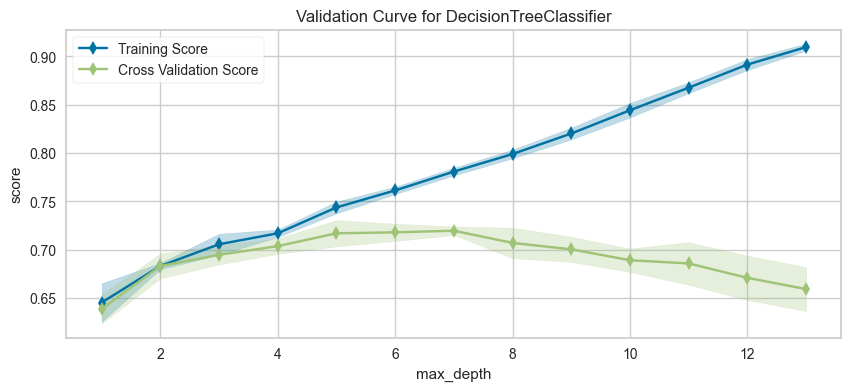

In [26]:
from yellowbrick.model_selection import validation_curve

fig,ax=plt.subplots(figsize=(10,4))
viz=validation_curve(tree.DecisionTreeClassifier(),
                     X=pd.concat([Xtrain,Xtest]),
                     y=pd.concat([kag_y_train,kag_y_test]),
                     param_name='max_depth',param_range=range(1,14),
                     scoring='accuracy',cv=5,ax=ax,n_jobs=6)

shaded area is due to cross validation score. thin shade is better because it shows consistency across each cross validation split

In [27]:
from sklearn.model_selection import GridSearchCV
params={ 
    'max_depth':[3,5,7,8],
    'min_samples_leaf':[1,2,3,4,5,6],
    'min_samples_split':[2,3,4,5,6],
}

grid_search=GridSearchCV(estimator=tree.DecisionTreeClassifier(),
                         param_grid=params,
                         cv=4,
                         n_jobs=-1,
                         verbose=1,
                         scoring="accuracy")
grid_search.fit(pd.concat([Xtrain,Xtest]),
                pd.concat([kag_y_train,kag_y_test]))


Fitting 4 folds for each of 120 candidates, totalling 480 fits


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7, 8],
                         'min_samples_leaf': [1, 2, 3, 4, 5, 6],
                         'min_samples_split': [2, 3, 4, 5, 6]},
             scoring='accuracy', verbose=1)

In [28]:
grid_search.best_params_

{'max_depth': 7, 'min_samples_leaf': 5, 'min_samples_split': 6}

In [29]:
between2=tree.DecisionTreeClassifier(**grid_search.best_params_)
between2.fit(Xtrain,kag_y_train)
between2.score(Xtest,kag_y_test)

0.7259668508287292

In [ ]:
# (pd.DataFrame(grid_search.cv_results_)
#  .sort_values(by='rank_test_score')
#  .style
#  .background_gradient(axis='rows')
#  )

In [31]:
#random forest
from sklearn import ensemble
rf=ensemble.RandomForestClassifier(random_state=42)
rf.fit(Xtrain,kag_y_train)
rf.score(Xtest,kag_y_test)

0.7237569060773481

In [32]:
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [33]:
len(rf.estimators_)
# number of decision trees created

100

[Text(0.5, 0.875, 'Q3_United States of America <= 0.5\ngini = 0.496\nsamples = 1354\nvalue = [1146, 964]\nclass = Data Scientist'),
 Text(0.25, 0.625, 'r <= 0.5\ngini = 0.496\nsamples = 681\nvalue = [496, 588]\nclass = Software Engineer'),
 Text(0.125, 0.375, 'education <= 17.0\ngini = 0.469\nsamples = 530\nvalue = [317, 528]\nclass = Software Engineer'),
 Text(0.0625, 0.125, '\n  (...)  \n'),
 Text(0.1875, 0.125, '\n  (...)  \n'),
 Text(0.375, 0.375, 'education <= 17.0\ngini = 0.376\nsamples = 151\nvalue = [179, 60]\nclass = Data Scientist'),
 Text(0.3125, 0.125, '\n  (...)  \n'),
 Text(0.4375, 0.125, '\n  (...)  \n'),
 Text(0.75, 0.625, 'education <= 17.0\ngini = 0.464\nsamples = 673\nvalue = [650, 376]\nclass = Data Scientist'),
 Text(0.625, 0.375, 'major_cs <= 0.5\ngini = 0.485\nsamples = 176\nvalue = [109, 154]\nclass = Software Engineer'),
 Text(0.5625, 0.125, '\n  (...)  \n'),
 Text(0.6875, 0.125, '\n  (...)  \n'),
 Text(0.875, 0.375, 'major_cs <= 0.5\ngini = 0.413\nsamples = 49

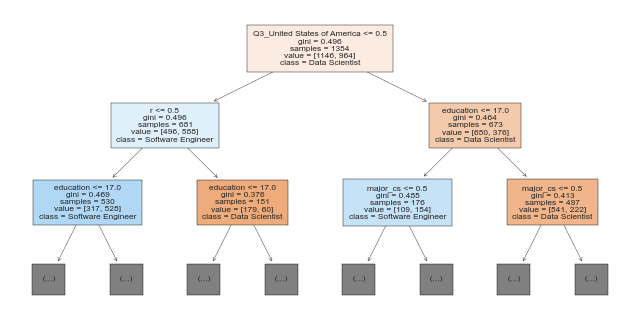

In [35]:
fig,ax=plt.subplots(figsize=(8,4))
features=list(c for c in Xtrain.columns)
tree.plot_tree(rf.estimators_[0],feature_names=features,
               filled=True,
               class_names=rf.classes_,
               ax=ax,
               max_depth=2,
               fontsize=6)

column subsampling is a possible explanation as to why Q3_usa is the first column

In [37]:
# XGBOOST random forest
xg_forst=xgb.XGBRFClassifier(random_state=42)
xg_forst.fit(Xtrain,ytrain)
xg_forst.score(Xtest,ytest)

0.7458563535911602

In [39]:
# xg_forst.get_params()

<AxesSubplot:>

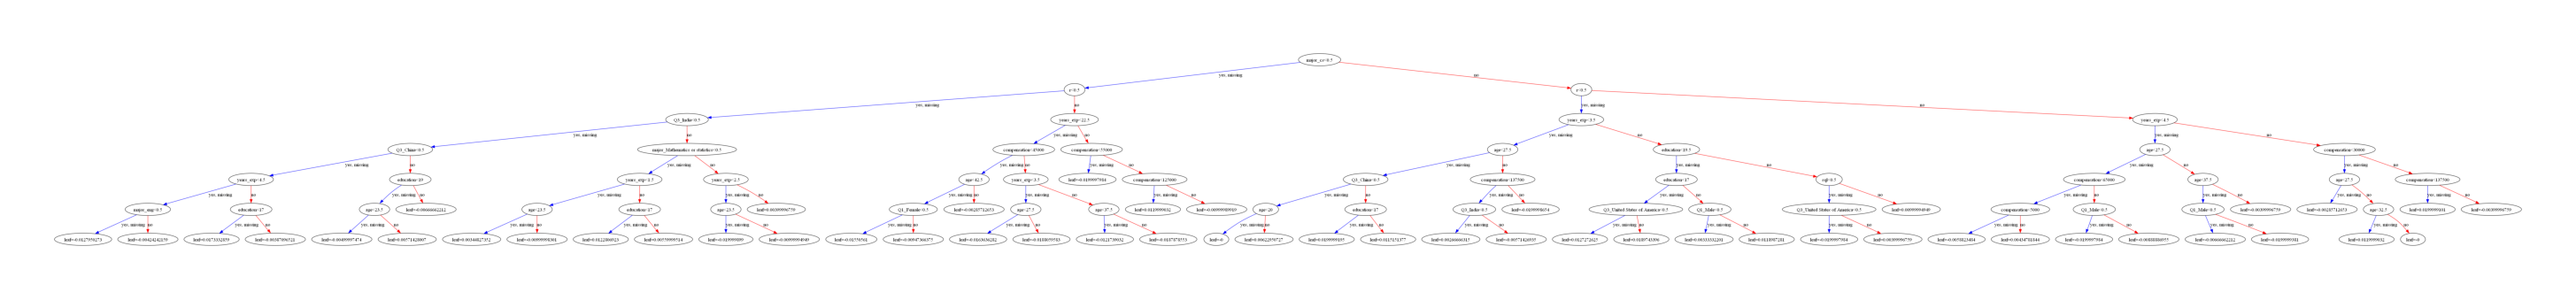

In [45]:
import dtreeviz
fig,ax=plt.subplots(figsize=(6,12),dpi=600)
xgb.plot_tree(xg_forst,num_trees=0,ax=ax,size='1,1')

# my_dot_export(xg_forst,num_trees=0,filename="img/rf_xg_kag.dot",title='[0]Random forest tree',direction='LR')

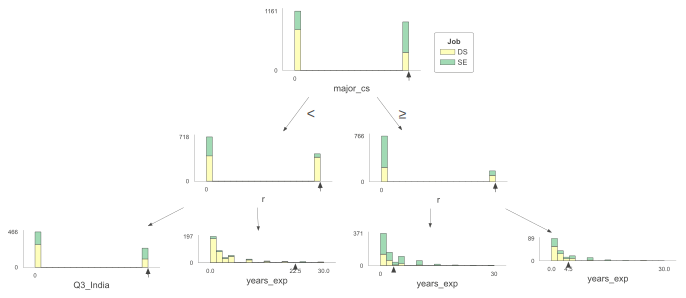

In [49]:
viz=dtreeviz.model(xg_forst,X_train=Xtrain,y_train=ytrain,
                   target_name='Job',
                   feature_names=list(Xtrain.columns),
                   class_names=['DS','SE'],
                   tree_index=0)
viz.view(depth_range_to_display=[0,2])